In [ ]:
!pip install datasets transformers accelerate torch scikit-learn matplotlib

In [ ]:
from datasets import load_dataset

dataset = load_dataset('jbarat/plant_species')
dataset

README.md:   0%|          | 0.00/800 [00:00<?, ?B/s]

(…)-00000-of-00001-15efca0bf2e6a460.parquet:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})

In [ ]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['aechmea_fasciata', 'agave_americana', 'agave_attenuata', 'agave_tequilana', 'aglaonema_commutatum', 'albuca_spiralis', 'allium_cepa', 'allium_sativum'], id=None)}

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('jbarat/plant_species')

# Split the training data into train and test (let's say 20% for the test set)
train_test_split = dataset['train'].train_test_split(test_size=0.1)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],  # Validation set
    'test': train_test_split['test']  # Test set
}

# Display the structure of the final dataset
final_dataset


{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 648
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 72
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 80
 })}

In [ ]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x500>,
 'label': 5}

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['aechmea_fasciata', 'agave_americana', 'agave_attenuata', 'agave_tequilana', 'aglaonema_commutatum', 'albuca_spiralis', 'allium_cepa', 'allium_sativum'], id=None)}

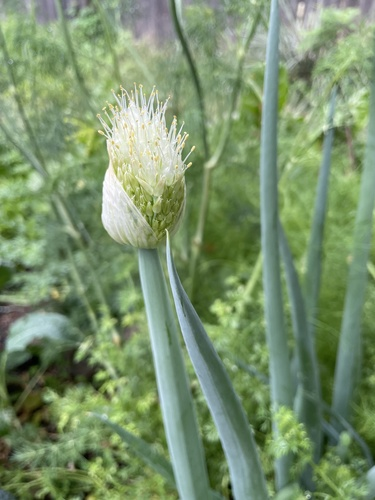

In [ ]:
image = train_ds[1]['image']
image

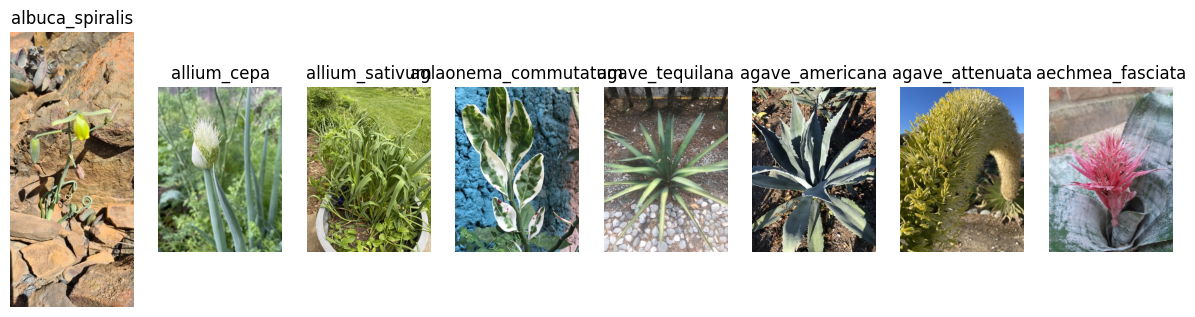

In [ ]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(15, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

plt.show()

In [ ]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'aechmea_fasciata',
  1: 'agave_americana',
  2: 'agave_attenuata',
  3: 'agave_tequilana',
  4: 'aglaonema_commutatum',
  5: 'albuca_spiralis',
  6: 'allium_cepa',
  7: 'allium_sativum'},
 'albuca_spiralis')

In [ ]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [27]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [28]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

In [29]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [30]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [31]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


['aechmea_fasciata',
 'agave_americana',
 'agave_attenuata',
 'agave_tequilana',
 'aglaonema_commutatum',
 'albuca_spiralis',
 'allium_cepa',
 'allium_sativum']

In [44]:
from transformers import ViTForImageClassification
labels  = dataset['train'].features['label'].names
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([8, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss
10,1.902000,1.224669
20,1.040100,0.598922
30,0.725900,0.441743
40,0.759900,0.234157
50,0.515100,0.329987
60,0.376000,0.315651
70,0.344700,0.269771
80,0.306700,0.213706


TrainOutput(global_step=82, training_loss=0.7311958379861785, metrics={'train_runtime': 333.383, 'train_samples_per_second': 3.887, 'train_steps_per_second': 0.246, 'total_flos': 3.550258957147177e+17, 'train_loss': 0.7311958379861785, 'epoch': 2.0})

In [52]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.38651418685913086, 'test_runtime': 1.4459, 'test_samples_per_second': 55.328, 'test_steps_per_second': 6.916}


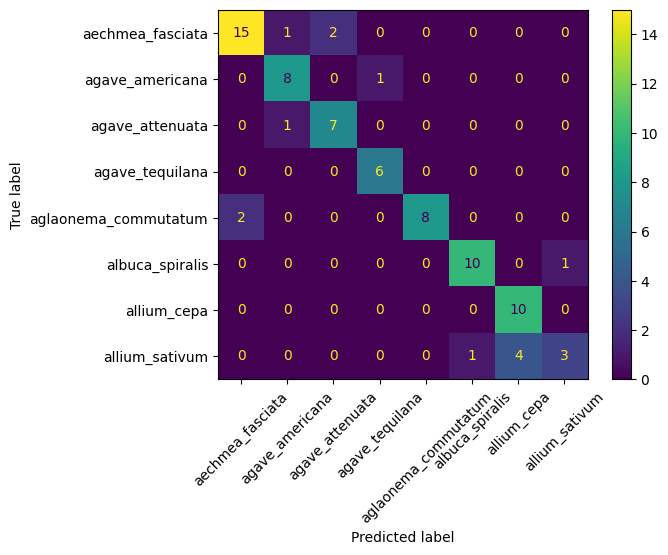

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [58]:
from sklearn.metrics import classification_report

target_names = id2label.values()

print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

    aechmea_fasciata       0.88      0.83      0.86        18
     agave_americana       0.80      0.89      0.84         9
     agave_attenuata       0.78      0.88      0.82         8
     agave_tequilana       0.86      1.00      0.92         6
aglaonema_commutatum       1.00      0.80      0.89        10
     albuca_spiralis       0.91      0.91      0.91        11
         allium_cepa       0.71      1.00      0.83        10
      allium_sativum       0.75      0.38      0.50         8

            accuracy                           0.84        80
           macro avg       0.84      0.84      0.82        80
        weighted avg       0.84      0.84      0.83        80



In [56]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.84
